In [1]:
import numpy as np
from numpy.random import default_rng
import pandas as pd
import scipy.optimize as opt
import matplotlib.pyplot as plt
import seaborn as sns
from typing import NamedTuple

from fct import PVTrainDataSet, PVTestDataSet

In [2]:
beta_a_true = 1
beta_w_true = 0.1
pi_w_true = 5

def psi(t: np.ndarray) -> np.ndarray:
    return 2 * ((t - 5) ** 4 / 600 + np.exp(-4 * (t - 5) ** 2) + t / 10 - 2)

def cal_outcome(A, W, U, params):
    beta_a, beta_w, pi_w  = params
    return np.exp((beta_a*A + beta_w*W)/10) + pi_w*psi(U) # changed

def generatate_data(n_sample: int, params, rng, Z_noise: float = 1, W_noise: float = 1, Y_noise: float = 1):
    U = rng.uniform(0, 10, n_sample)
    Z1 = 2 * np.sin(U * np.pi * 2 / 10) + rng.normal(0, Z_noise, n_sample)
    Z2 = 2 * np.cos(U * np.pi * 2 / 10) + rng.normal(0, Z_noise, n_sample)
    A = (Z1 + 3) * psi(U) + Z2 + rng.normal(0, 1.0, n_sample) # changed so no intercept
    W = psi(U) + rng.normal(0, W_noise, n_sample) # changed so no intercept + slope
    Y = (cal_outcome(A, W, U, params) + rng.normal(0, Y_noise, n_sample)).astype(float)
    return U, Z1, Z1, A, W, Y

def generate_train_data(n_sample: int, params,
                        Z_noise: float = 1, W_noise: float = 1, Y_noise: float = 1, seed=42):
    rng = default_rng(seed=seed)
    U, Z1, Z2, A, W, Y = generatate_data(n_sample, params, rng, Z_noise, W_noise, Y_noise)
    return PVTrainDataSet(treatment=A,
                          treatment_proxy=np.c_[Z1, Z2],
                          outcome_proxy=W,
                          outcome=Y
                         )

def cal_true_effect(a: float, params, 
                    W_noise: float = 1, n_sample: int = 10000):
    rng = default_rng(seed=42)
    U = rng.uniform(0, 10.0, n_sample)
    W = psi(U) + rng.normal(0, W_noise, n_sample)
    Y = cal_outcome(a, W, U, params)
    return np.mean(Y)


def generate_eval_data(params, a_start: float = -2, a_end: float = 2, n_steps: int = 100):
    a_steps = np.linspace(a_start, a_end, n_steps)
    struc = np.array([cal_true_effect(a, params) for a in a_steps])
    return PVTestDataSet(treatment=a_steps,
                         structural=struc,
                         )

In [3]:
n_sample = 10000
random_seed = 50
params_true = np.array([beta_a_true, beta_w_true, pi_w_true])

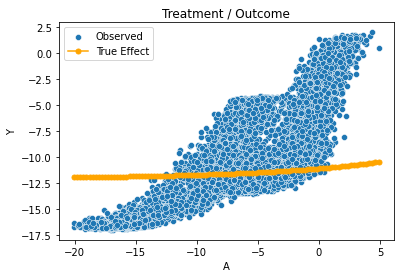

In [4]:
# train
train_data = generate_train_data(n_sample=n_sample, params=params_true, 
                        Z_noise = 0.1, W_noise = 0.1, Y_noise = 0.1, seed=random_seed)
# val
val_data = generate_train_data(n_sample=n_sample, params=params_true, 
                        Z_noise = 0.1, W_noise = 0.1, Y_noise = 0.1, seed=random_seed+1)

A = train_data.treatment
Y = train_data.outcome

# eval
eval_data = generate_eval_data(params=params_true, a_start= min(A), a_end = max(A), n_steps = 100)

a_eval = eval_data.treatment
y_true = eval_data.structural

# predictions
# y_pred = np.array(pred)
# a_treat = np.squeeze(a)
# y_true = eval_data.structural.squeeze()



sns.scatterplot(x=A, y=Y, label='Observed')
plt.plot(a_eval, y_true, color='orange', marker='o', label="True Effect", markersize=5)
plt.title('Treatment / Outcome')
plt.xlabel('A')
plt.ylabel('Y')
plt.legend()
plt.show()

In [5]:
def model(A, W, params): # without U
    beta_a, beta_w, pi_w  = params
    return np.exp((beta_a*A + beta_w*W)/10) + pi_w * W # model specific

def g_vec(y, var_model, var_inst, params):
    """
    y: outcome
    var_model: A, W
    var_inst: A, Z1, Z2
    """
    error = y - model(var_model[:, 0], var_model[:, 1], params)
    m1 = np.mean(var_inst[:, 0] * error)
    m2 = np.mean(var_inst[:, 1] * error)
    m3 = np.mean(var_inst[:, 2] * error)
    g =  np.column_stack((m1, m2, m3)).T
    return g

In [12]:
def criterion(params, *var):
    y, var_model, var_inst, W = var
    g = g_vec(y, var_model, var_inst, params)
    crit_val = np.dot(np.dot(g.T, W), g) 
    return crit_val

In [13]:
beta_a_init = 0
beta_w_init = 0
pi_w_init = 0
params_init = np.array([beta_a_init, beta_w_init, pi_w_init])
W_hat = np.eye(3)

a = train_data.treatment
y = train_data.outcome
w = train_data.outcome_proxy
z = train_data.treatment_proxy
var_model = np.c_[a, w]
var_inst = np.c_[a, z]
gmm_args = (y, var_model, var_inst, W_hat)
print("Initial Results:", criterion(params_init, *gmm_args))

results = opt.minimize(criterion, params_init, args=(gmm_args), tol=1e-6, options  = {"maxiter":100000, "disp":True})
results

Initial Results: [[14482.55246691]]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 32
         Function evaluations: 160
         Gradient evaluations: 40


      fun: 4.031076855951697e-14
 hess_inv: array([[ 3.50303641e+00, -1.35076219e+01,  2.17282646e-02],
       [-1.35076219e+01,  5.21067666e+01, -8.42755725e-02],
       [ 2.17282646e-02, -8.42755725e-02,  1.09177676e-03]])
      jac: array([-5.38175429e-07, -1.39477803e-07, -3.67542209e-09])
  message: 'Optimization terminated successfully.'
     nfev: 160
      nit: 32
     njev: 40
   status: 0
  success: True
        x: array([1.30154025, 0.14627721, 4.97131418])

In [14]:
params_pred = results.x
# params_pred = params_true # sanity check


a_temp = eval_data.treatment.reshape(-1, 1)
w_temp = val_data.outcome_proxy.reshape(-1, 1)
n_test_samples = a_temp.shape[0]
n_val_samples = w_temp.shape[0]
temp_A = np.broadcast_to(a_temp,(a_temp.shape[0], n_val_samples))
temp_W = np.broadcast_to(w_temp,(w_temp.shape[0], n_test_samples))
AW_test = np.stack((temp_A, temp_W.T), axis=-1)
y_pred = [np.mean(model(AW_test[i, :, 0], AW_test[i, :, 1], params=params_pred)) for i in range(AW_test.shape[0])]

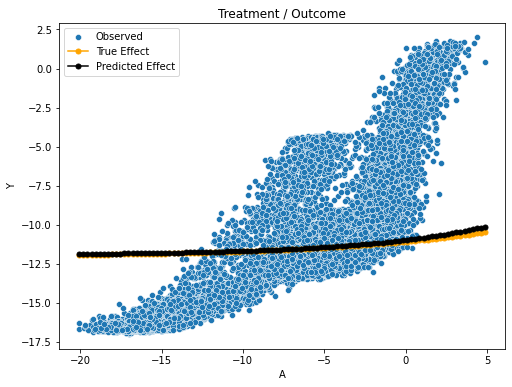

In [15]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=A, y=Y, label='Observed')
plt.plot(a_eval, y_true, color='orange', marker='o', label="True Effect", markersize=5)
plt.plot(a_eval, y_pred, color='black', marker='o', label="Predicted Effect", markersize=5)
plt.title('Treatment / Outcome')
plt.xlabel('A')
plt.ylabel('Y')
plt.legend()
plt.show()